#### Set-up for Colab
Install dependencies, mount drive, etc.

In [1]:
pip install -q -U tensorflow-text

In [2]:
pip install -q tf-models-official==2.4.0

In [ ]:
pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
path = 'drive/MyDrive/MIDS/chemical_patent_cer_ee'

#### Import Libraries

In [2]:
import os
import io
import re
import sys
import sys
sys.path.append('/content/drive/MyDrive/MIDS/chemical_patent_cer_ee/notebooks')

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

import pickle
from csv import reader

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

from sre_inputs import *
from train_test import *
from sre_models import *

#### BERT Model

In [3]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
max_length = 500

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Data
- Upload preprocessed chemical patent file(s)
- Use `sre_inputs` module to generate inputs for model
- Sample only: split into train/test using `train_test` module
- One hot encode labels 

In [4]:
# full_path = '../data/sre_em/sre_em_sample.csv'
full_path = f'{path}/data/sre_em/sre_em_sample.csv'

In [5]:
all_lists = generate_entity_inputs(full_path, tokenizer, marker_type='em', head_type='start', max_length=500)

In [6]:
train_all, test_all = train_test_split(all_lists)

In [7]:
model_inputs_train = [train_all[0][0], train_all[0][1], train_all[0][2], train_all[0][3], train_all[0][4]]
model_labels_train = train_all[1]
model_labels_train = tf.one_hot(model_labels_train, depth=2)

In [8]:
type(model_inputs_train)

list

In [9]:
len(model_labels_train)

453

In [10]:
len(model_inputs_train[0])

453

In [11]:
model_inputs_test = [test_all[0][0], test_all[0][1], test_all[0][2], test_all[0][3], test_all[0][4]]
model_labels_test = test_all[1]
model_labels_test = tf.one_hot(model_labels_test, depth=2)

In [12]:
len(test_all[0][4])

205

In [13]:
len(model_inputs_test[0])

205

In [14]:
len(model_labels_test[0])

2

#### Run Model(s)

In [15]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

model = sre_start_model(bert_model, max_length)

model.fit(
    model_inputs_train, 
    {"sre": model_labels_train},
    validation_data=(model_inputs_test, {"sre": model_labels_test}),
    epochs=5,
    batch_size=16
)


=== SRE Start Entity Model ===
BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 500, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model'")
Prediction: KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='sre/Softmax:0', description="created by layer 'sre'")

Model: "sre_pool"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 500)]        0           []                               
                                                                   

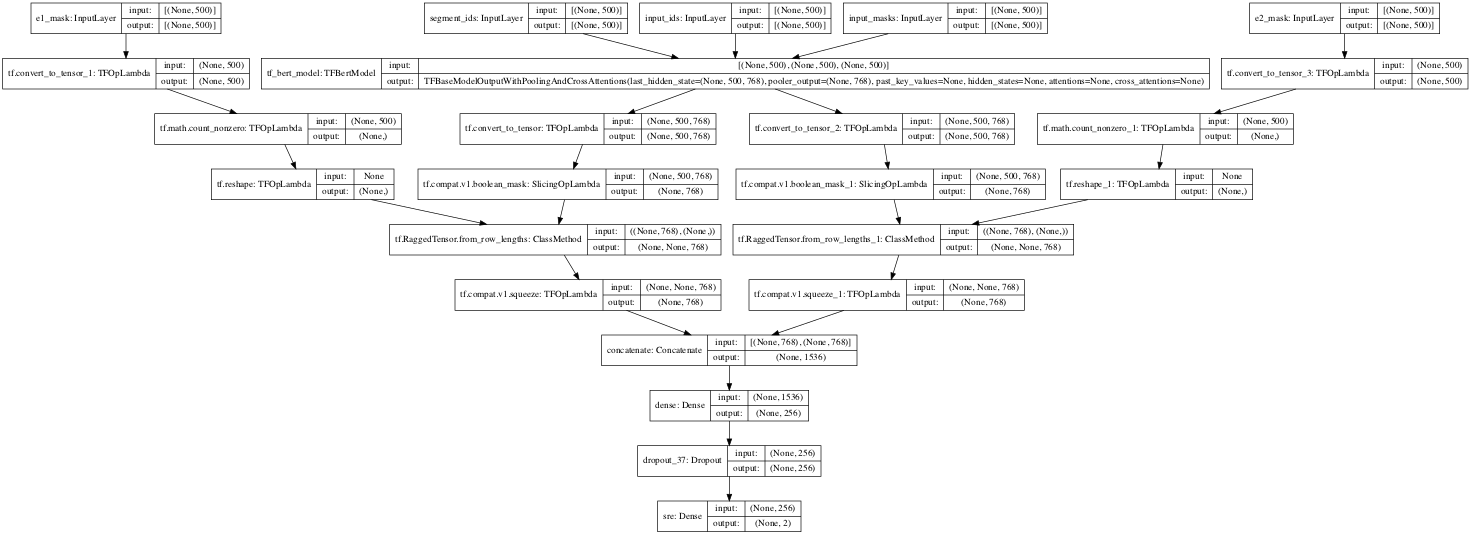

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [16]:
model.save(f'{path}/models/sample1')

IndexError: ignored